# SEIRModel_share
In this file, we summarize the work from SEIRModeling. For more details, including details on the model, see the original. 

## Setup
Run this to initialize all necessary functions.

The functions listed here 
- extract data from the database
- plot this data
- encode our differential model
- fit to the model

In [156]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
from datetime import date, timedelta
import lmfit
#from seirsplus.models import *
from scipy.integrate import odeint

In [172]:
def get_HR_name(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()
    
    cursor.execute('SELECT ENGNAME FROM HR WHERE HR_UID = ' + str(HR_UID))
    rows = cursor.fetchall()
    if len(rows) == 0:
        print("No HR with that UID")
        return None
    
    return rows[0][0]

# Use to get data from the Covid19 table. 
#    columns : a string of column names from the Covid19 table, must be separated by ', '. Eg 'dates, cases'
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_data(columns, HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT ' + columns + ' FROM Covid19 WHERE HR_UID = ' + str(HR_UID))
    results = pd.DataFrame(cursor.fetchall())
    results.columns = columns.split(', ')
    #print(results[:5])
    cursor.close()
    conn.close()
    
    return results

# Use to get all the health indicators for a health region from the Health_Indicators_ODHF table as a dictionary. 
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_dict(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT * FROM Health_Indicators_ODHF WHERE HR_UID == ' + str(HR_UID))
    tuples = cursor.fetchall()
    if len(tuples) == 0:
        print("No HR with that UID")
        return None

    results = [tuples[0][y] for y in range(len(tuples[0]) - 1)]
    keys = [cursor.description[y][0] for y in range(len(cursor.description) - 1)]

    hr_dict = {}
    for key in zip(keys,results):
        hr_dict[key[0]] = key[1]

    return hr_dict

# Plot the data returned by get_HR_data. 
#    df : a dataframe of the from returned by get_HR_data
#    column : name of column (or columns) to plot. If None, then plots all columns. Should be a string of the same form as in get_HR_data
#    hr_name : name of the HR plotted, as a string. Prints the name of the HR in the title.
def plot_frame(df, column = None, hr_name = None):
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

    # Set up the plot
    fig, ax = plt.subplots(figsize = (19,10))
    dates = df['report_date'].apply(lambda x : np.datetime64(x))
    if column == None:
        column = list(df.columns[1:])
    else:
        column = column.split(', ')
    for col in column:
        ax.scatter(dates, df[col])

    # Set the axis
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(days)

    # Set the axis ranges
    datemin = dates[0]
    datemax = dates[len(dates) - 1]
    ax.set_xlim(datemin, datemax)

    # More axis stuff
    ax.format_xdata = mdates.DateFormatter("%m-%d")
    ax.grid(True)
    fig.autofmt_xdate()
    
    plt.title("Data about " + ", ".join(column) + " by day" + ("" if hr_name == None else ' in ' + hr_name), fontdict = {'fontsize': 20} )
    plt.legend(column, fontsize = 15)

    return fig, ax, plt

def deriv(y, t, beta, delta, rho, alpha, gamma, N):
    S, E, I, D, R = y # y wraps up all the compartments
    
    
    dSdt = - S * I * beta(t) / N
    dEdt = S * I * beta(t) / N - delta * E
    dIdt = delta * E - rho * alpha * I - gamma * (1 - alpha) * I
    dDdt = rho * alpha * I
    dRdt = gamma * (1 - alpha) * I
    
    return dSdt, dEdt, dIdt, dDdt, dRdt

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, N, R_0_start, k, x0, R_0_end):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    y0 = N - 1.0, 1.0, 0.0, 0.0, 0.0 # Initial population; just one exposed person
    
    t = np.linspace(0, days - 1, int(days))
    ret = odeint(deriv, y0, t, args=(beta, delta, rho, alpha, gamma, N))
    S, E, I, D, R = ret.T
    
    # this is R_0 throughout for plotting
    R_0_over_time = [beta(i) / gamma for i in range(len(t))]
    beta_over_time = [beta(i) for i in range(len(t))]
    
    return t, S, E, I, D, R, R_0_over_time, beta_over_time

# def Model(days, N, model):
#     R_0_start, k, x0, R_0_end = model.best_values.values()
#     return Model(days, N, R_0_start, k, x0, R_0_end)

def plotting(t, S, E, I, D, R, R_0_over_time, beta_over_time, x_ticks = None):
    f,ax = plt.subplots(1,1,figsize=(15,4))
    ax.title.set_text("SEIDR Model")
    
####!=
    if x_ticks is not None:
        months = mdates.MonthLocator()
        days = mdates.DayLocator()
        years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

        # Set up the plot
        dates = x_ticks.apply(lambda x : np.datetime64(x))

        # Set the axis
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.xaxis.set_minor_locator(days)

        # Set the axis ranges
        datemin = dates[0]
        datemax = datemin + timedelta(days=len(t) - 1)
        ax.set_xlim(datemin, datemax)

        ax.format_xdata = mdates.DateFormatter("%m-%d")
        #ax.grid(True)
        f.autofmt_xdate()
        
        t = pd.date_range(start = datemin, end = datemax)
####
    def annihilate_small_values(compartment):
        return [compartment[i] if compartment[i] >=1 else 1 for i in range(len(compartment))]

    ax.plot(t, annihilate_small_values(S), 'b', alpha = 0.7, linewidth = 2, label='Susceptible')
    ax.plot(t, annihilate_small_values(E), 'y', alpha = 0.7, linewidth = 2, label='Exposed')
    ax.plot(t, annihilate_small_values(I), 'r', alpha = 0.7, linewidth = 2, label='Infected')
    ax.plot(t, annihilate_small_values(D), 'k', alpha = 0.7, linewidth = 2, label='Dead')
    ax.plot(t, annihilate_small_values(R), 'g', alpha = 0.7, linewidth = 2, label='Recovered')
    ax.set_yscale('log')

    legend = ax.legend()
    ax.grid(b = False, which = 'minor',c='w', lw = 2, ls = '-')

    
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)


    plt.show()

    f = plt.figure(figsize = (15,4))
    # Plot of R_0 over time
    ax1 = f.add_subplot(131)
    ax1.plot(t, R_0_over_time, alpha = 0.7, linewidth=2, label='R_0')
    ax1.title.set_text('Daily R_0 value')
    legend = ax1.legend()
    for spine in ('top','right','bottom','left'):
        ax1.spines[spine].set_visible(False)
    
    # Plot of total infected death rate. Calculated as total deaths divided by everyone who's been infected up to that point.
    # Denominator is calculated as delta * sum(E[:t]), because that is all the people added to the I compartment.
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta * E[:i]) if sum(delta * E[:i]) > 0 else 0 for i in range(1, len(t))]
    ax2.plot(t, total_CFR, alpha = 0.7, linewidth = 2, label = 'Death Rate among Infected')
    legend = ax2.legend()
    ax2.title.set_text("Death Rate %")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax2.spines[spine].set_visible(False)

    # Plot of deaths per day.
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i] - D[i - 1] for i in range(1, len(t))]
    ax3.plot(t, newDs, alpha = 0.7, linewidth=2, label="Daily Deaths")
    ax3.title.set_text("Deaths Per Day")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax3.spines[spine].set_visible(False)
        
    f.autofmt_xdate()
    plt.show()
    
    
def fitter(x, days, N, R_0_start, k, x0, R_0_end):
    ret = Model(days= days, N = N, R_0_start = R_0_start, k = k, x0 = x0, R_0_end = R_0_end)
    
    return ret[4][x] # return the xth value of Deaths, which is 4 in the return list of Model



## Running the model
Now, we can actually fit the model.

Set up the parameters for the model;

In [142]:
mod = lmfit.Model(fitter, independent_vars = ['x','days', 'N'])

mod.set_param_hint("R_0_start", value = 5.7, min = 1, max = 15, vary = True)
mod.set_param_hint("k", value = 2, min = .001, max = 5, vary = True)
mod.set_param_hint("x0", value = 60, min = 10, max = 150, vary = True)
mod.set_param_hint("R_0_end", value = 1.1, min = 0.01, max = 2.5, vary = True)

params = mod.make_params()
fit_method = 'leastsq'

Pick the health region;

<class 'dict'>


(<Figure size 1368x720 with 1 Axes>,
 <module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

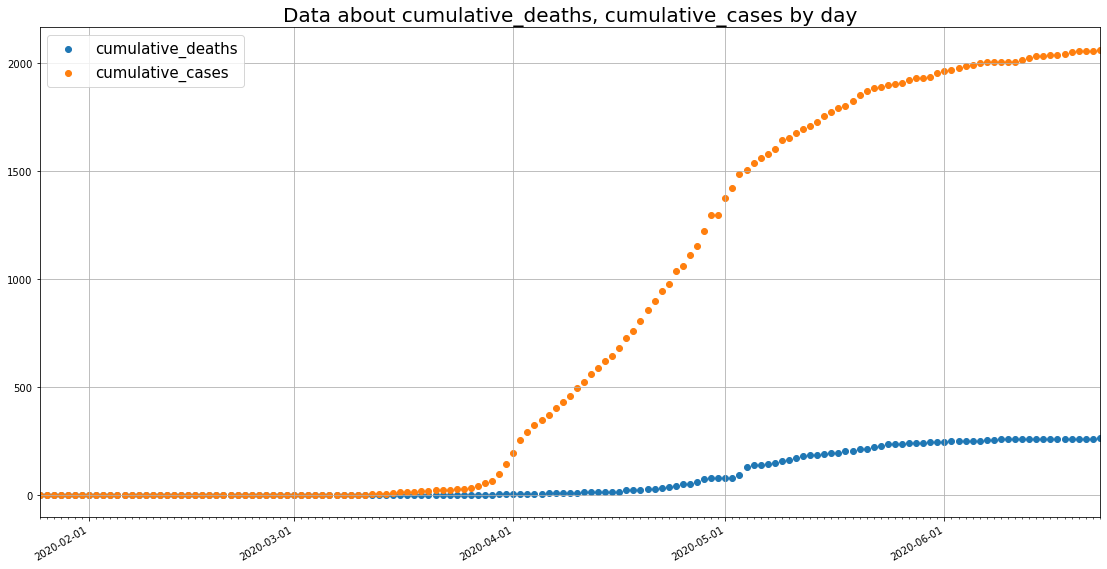

In [143]:
#=========================================================================
HR_UID = 3551 # 3551 is Ottawa, 3595 is Toronto
#=========================================================================
hr_dict = get_HR_dict(HR_UID) 
print(dict)
df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 
df.head()
plot_frame(df)

Get the data we need; deaths_less_a_week is the cumulative_deaths data without the last days_back days. This way, we model based less data and compare that model's predictions to the real data.

In [144]:
days_back = 7
deaths = np.array(df["cumulative_deaths"])
deaths_less = deaths[:-days_back]
cases = np.array(df["cumulative_cases"])
days = len(deaths_less)
x_dat = np.linspace(0,days-1, days, dtype=int)
N = hr_dict["Population_rate"]

Set up the virus parameters and fit the model;

In [145]:
delta = 1 / 5.0 # 1 / incubation period
rho =  1 / 12.0 # 1 / time from I to D
gamma = 1.0 / 19.2 # Recall gamma is 1 / time to recover from infection
alpha = deaths[-1] / cases[-(1 + int(np.floor(1 / gamma)))] # death rate

result = mod.fit(deaths_less, params, method = fit_method, x = x_dat, days = days, N = N)

View the result;

In [146]:
print(result.best_values)

result.plot_fit()
result

{'R_0_start': 3.393712843633097, 'k': 4.993465275894178, 'x0': 96.9971826164925, 'R_0_end': 0.010000000335414682}
Fit can only be plotted if the model function has one independent variable.


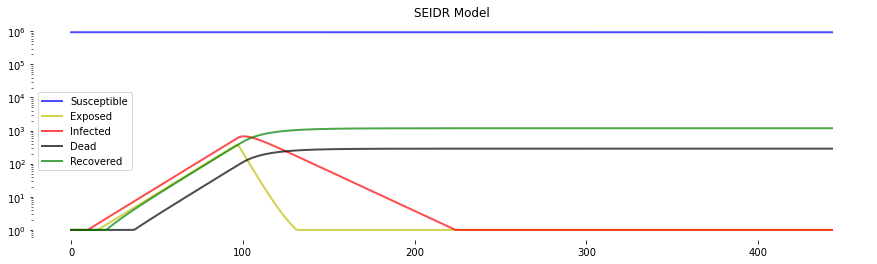

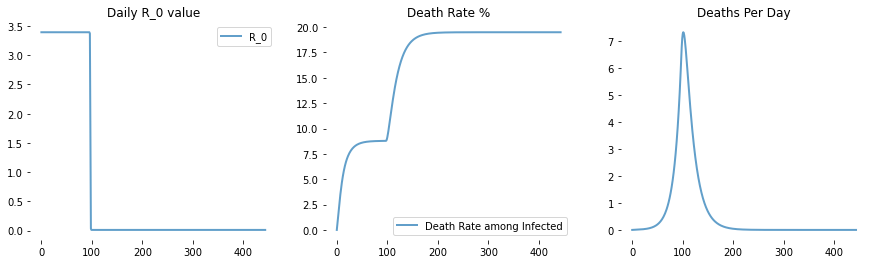

In [147]:
R_0_start, k, x0, R_0_end = result.best_values.values()
model = Model(days=days + 300, N=N, R_0_start=R_0_start, k=k, x0=x0, R_0_end=R_0_end)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model
plotting(*model)

In [148]:
# The largest the Infected compartment ever got
print("According to the model, the largest number of active infections: " + str(np.floor(np.max(I))))
# The total number of people who ever got infected
print("According to the model, the total number of cases is " + str(np.floor(sum(delta * E))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')

According to the model, the largest number of active infections: 669.0
According to the model, the total number of cases is 1461.0, compared to 2061 as reported in the covid data


## Now, we determine if we are high risk or not;
We compare the true deaths today to what the model would have predicted. If the model predicts more, then we have a low-risk region, and if the model predicts less then we have high-risk.

In [149]:
print('True deaths: ' + str(deaths[-1]))
print('Predicted deaths: ' + str(D[days+7]))
if deaths[-1] > D[days+7]:
    print("Thus, health region " + str(HR_UID) + " is a high-risk HR")
else:
    print("Thus, health region " + str(HR_UID) + " is a low-risk HR")

True deaths: 261
Predicted deaths: 273.76234105217355
Thus, health region 3551 is a low-risk HR


## Function to perform modeling;

In [162]:
def fit_SEIDR_model(HR_UID, days_to_ignore = None, delta = 1 / 5.0, rho = 1 / 12.0, gamma = 1 / 19.2, alpha = None):

    hr_dict = get_HR_dict(HR_UID) 
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 

    deaths = np.array(df["cumulative_deaths"])
    if days_to_ignore != None:
        deaths = deaths[:-days_to_ignore]
    cases = np.array(df["cumulative_cases"])
    days = len(deaths)
    x_dat = np.linspace(0, days - 1, days, dtype=int)
    
    N = hr_dict["Population_rate"]

    if alpha == None:
        alpha = deaths[-1] / cases[-(1 + int(np.floor(1 / gamma)))] # death rate

    
    mod = lmfit.Model(fitter)
        
    mod.set_param_hint("R_0_start", value = 5.7, min = 1, max = 15, vary = True)
    mod.set_param_hint("k", value = 2, min = .001, max = 5, vary = True)
    mod.set_param_hint("x0", value = 60, min = 10, max = 150, vary = True)
    mod.set_param_hint("R_0_end", value = 1.1, min = 0.01, max = 2.5, vary = True)
    mod.set_param_hint("days",value = days, vary = False)
    mod.set_param_hint("N", value = N, vary = False)
    
    params = mod.make_params()
    fit_method = 'leastsq'
        
    #result = mod.fit(deaths, params, method = fit_method, x = x_dat, days = days, N = N)
    result = mod.fit(deaths, params, method = fit_method, x = x_dat)
    return result

In [164]:
HR_UID = 3551
res = fit_SEIDR_model(3551)

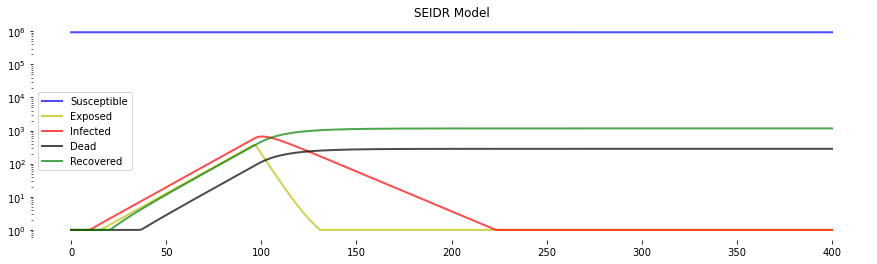

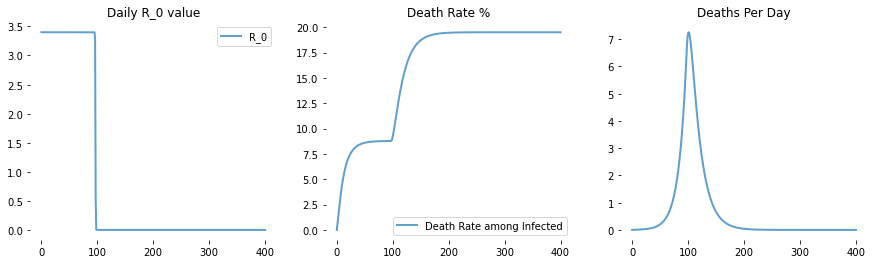

In [165]:
days, N, R_0_start, k, x0, R_0_end = res.best_values.values()
model = Model(days + 250, N, R_0_start, k, x0, R_0_end)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model
plotting(*model)

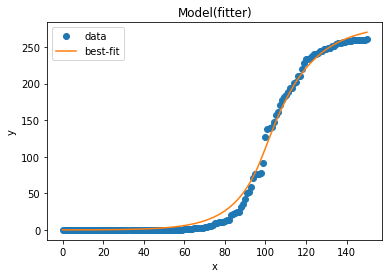

In [167]:
res.plot_fit()

In [175]:
print(get_HR_name(HR_UID))
print("According to the model, the largest number of active infections: " + str(np.floor(np.max(I))))
print("According to the model, the total number of cases is " + str(np.floor(sum(delta * E))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')
print()
print('True deaths: ' + str(deaths[-1]))
print('Predicted deaths: ' + str(D[days+7]))
if deaths[-1] > D[days+7]:
    print("Thus, health region " + str(HR_UID) + " is a high-risk HR")
else:
    print("Thus, health region " + str(HR_UID) + " is a low-risk HR")

City of Ottawa Health Unit
According to the model, the largest number of active infections: 661.0
According to the model, the total number of cases is 1444.0, compared to 2061 as reported in the covid data

True deaths: 261
Predicted deaths: 274.2845625260451
Thus, health region 3551 is a low-risk HR


In [174]:
HR_UID = 3551

In [176]:
def predict_risk(HR_UID, result, model):
    days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = result.best_values.values()
    
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 
    deaths = np.array(df["cumulative_deaths"])
    cases = np.array(df['cumulative_cases'])

    print("Interested in HR: " + str(HR_UID) + get_HR_name(HR_UID))
    print("According to the model, the total number of cases is " + str(np.floor(sum(delta * model[2]))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')
    print()
    print('True deaths: ' + str(deaths[-1]))
    print('Predicted deaths: ' + str(model[4][days+7]))
    if deaths[-1] > model[4][days+7]:
        print("Thus, health region " + str(HR_UID) + " is a high-risk HR")
    else:
        print("Thus, health region " + str(HR_UID) + " is a low-risk HR")
    
    